In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

In [2]:
# resizing of the data created with monte carlo

lt, ut, t_step = 1.0, 3.2, 0.003

#for L in [10, 15, 20]:
 #   utils.resize_data(L, lt, ut)
    
utils.resize_data_test(10)

In [30]:
L=10
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant
data = np.load(f"data/{L}_test_tanti.npy")#.reshape(-1, 100)
temps = np.load(f"data/{L}_temp_tanti.npy")#.reshape(-1, 1)

# target value
t = ((temps > 2.5) | (temps < 2.0)).astype(int)

# removing data close to T_CRIT
idx = np.where(t==1)
data = data[idx]
temps = temps[idx]
n = data.shape[0]
t = (temps > T_CRIT).astype(int)

# DATA Shuffling
rng = np.random.default_rng()
indices = np.arange(data.shape[0])
rng.shuffle(indices)

data = data[indices]
t = t[indices]
temps = temps[indices]

# splitting data in 80% training, 20% validation, 10% test
a = int(0.9*n)
data_train = data[:a]
data_val = data[a:]

t_train = t[:a]
t_val = t[a:]

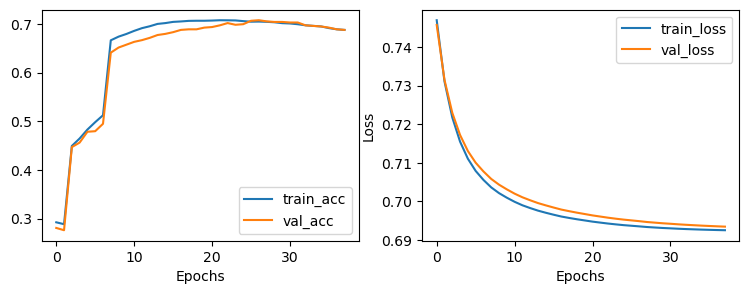

In [36]:
# CLASSIFIER TRAINING
clf = MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.0001, batch_size=200, momentum=0.9, solver='sgd', alpha=1, power_t=0.01)
clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
E = len(clf.train_acc) 
ax1.plot(np.arange(E), clf.train_acc)
ax1.plot(np.arange(E), clf.val_acc)
ax1.legend(["train_acc", "val_acc"])

ax2.plot(np.arange(E), clf.train_loss)
ax2.plot(np.arange(E), clf.val_loss)
ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])

In [32]:
b = clf.weights2.flatten()
b @ b.T

0.3303504819971447

In [47]:
for i in range(10):
    print(clf.score(data_test[i], t_test[4]))


0.7
0.7
0.8
0.6
0.75
0.7
0.8
0.8
0.7
0.8


In [53]:
clf.predict_probabilities(data_test[0])

array([[0.45426994],
       [0.47729331],
       [0.47729331],
       [0.45426994],
       [0.47729331],
       [0.48531553],
       [0.45426994],
       [0.45426994],
       [0.45426994],
       [0.48780836],
       [0.4554629 ],
       [0.47466992],
       [0.46835659],
       [0.49993587],
       [0.49205076],
       [0.49278826],
       [0.50784207],
       [0.48559469],
       [0.49002007],
       [0.51105411]])

<ErrorbarContainer object of 3 artists>

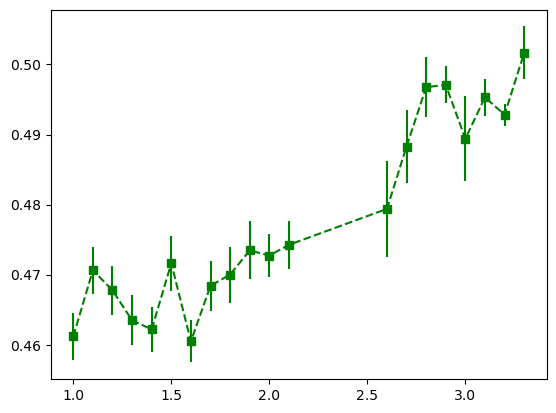

In [49]:
# loading data for testing
temp_test = np.load(f"./data/{L}_test_temp.npy")    # shape (10, 24)
data_test = np.load(f"./data/{L}_test.npy")         # shape (10, 24, 100)

# Create mask for filtering along axis 1
mask = (temp_test > 2.5) | (temp_test < 2.2)        # shape (10, 24), bool

# Filter each group, preserving the first dimension
filtered_temps = [temp_test[i][mask[i]] for i in range(temp_test.shape[0])]  # list of arrays, each (something,)
filtered_data = [data_test[i][mask[i]] for i in range(data_test.shape[0])]   # list of arrays, each (something, 100)

# Sort within each group
for i in range(len(filtered_temps)):
    sort_idx = np.argsort(filtered_temps[i])
    filtered_temps[i] = filtered_temps[i][sort_idx]
    filtered_data[i] = filtered_data[i][sort_idx]

# Optionally, convert lists to arrays for further processing
filtered_temps = np.array(filtered_temps)  # shape (10, something)
filtered_data = np.array(filtered_data)    # shape (10, something, 100)
temp_test = filtered_temps
data_test = filtered_data
t_test = (temp_test > T_CRIT).astype(int)

# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_probabilities(flattened).reshape(10, 20,1)

plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), y[:,:,0].std(axis=0)/np.sqrt(10), fmt='s--g')


## SKLEARN

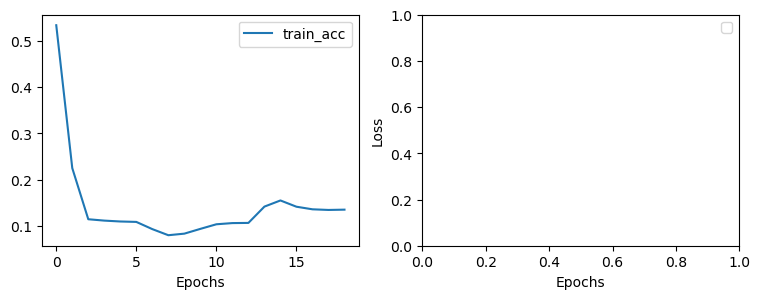

In [54]:
# training with sklearn

# using skleanr
clf = MLPClassifier(activation='relu', solver='sgd',alpha=0, momentum=1, nesterovs_momentum=False, power_t=1, verbose=False)
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


In [18]:
a = clf.coefs_[1].flatten()
a @ a.T

120.98633692847629

In [7]:
min(clf.loss_curve_)

0.00013774753575584485

In [55]:
clf.score(data_test[4], t_test[0])

0.95

In [64]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_proba(flattened).reshape(-1, 2)

In [66]:
y.shape

(200, 2)

ValueError: 'x' and 'y' must have the same size

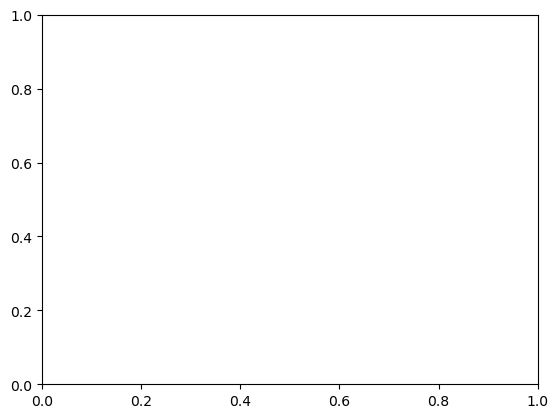

In [60]:
train_size = 10
errors = y[:,0].std(axis=0, ddof=1) / np.sqrt(train_size)  # std/(N-1)
plt.errorbar(temp_test[3], y[:,0].mean(axis=0), errors, fmt='s--g')

plt.grid(True)

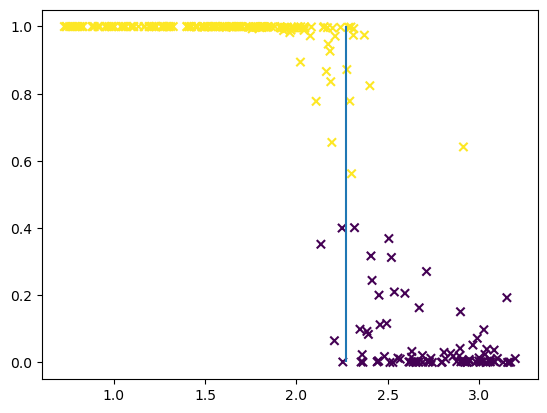

In [69]:
out = clf.predict_proba(data_val)
plt.scatter(temps[a:], out[:,1], marker='x', c=clf.predict(data_val) )
plt.vlines(T_CRIT, 0, 1)